# Spam-ham-info classification using CNN

Why CNNs generally don't tend to do better at text classification and the need for a better architecture or a better representation is justified?

## Human interpretation of text

When a human like you or me or anyone is given a piece of text, we read it word by word left to right top to bottom.

As we span through a sentence, we remember the previous words upto a certain length and every subsequent word in a sentence helps us understand more about that word and many others which occurred before it. Based on the task at hand, we forget the sentence we read as we go to a new one or keep it in our memory to connect it with something later.

This is a supremely complex task to ask a Computer to do because there's reading, writing, erasing of memory and simultaneously interpretation of the sentences which are read before. The human brain surely needs to be credited to do such tasks so effortlessly and yet not boast of it's capabilities. 

![Attention Span](attention_span.png)

[Image Source](https://www.explainxkcd.com/wiki/images/e/e4/attention_span.png)

## Human interpretation of images

When we see an image, we observe it all at once (well, if it's too big we observe it in parts but let's roll with the overall viewing hypothesis for now). That's how evolution worked it's way out and figured vision to be best optimized when we do it this way. There's a bunch of neurons which are locally connected and they're in turn connected locally to another higher layer which are connected to another higher layer and so on and it helps us comprehend images much faster and in a much more generalized way than having all neurons connected to all other neurons. 

After [Huber and Wiesel figured this out](https://knowingneurons.com/2014/10/29/hubel-and-wiesel-the-neural-basis-of-visual-perception/), taking inspiration from the working of a human brain's visual cortex, CNNs were built to make computers understand images and it did work wonders!

![CNN Biological Inspiration](CNN_biological_inspiration.png)

[Image Source](https://knowingneurons.com/2014/10/29/hubel-and-wiesel-the-neural-basis-of-visual-perception/)

The image above gives a brief understanding of how the idea for CNNs was inspired by the functioning of vision in human brain.

## Images vs text

From the above discussions it could be observed that the primary difference which makes text difficult to deal with compared to images is the way it's interpreted. Both of them images and text have spatial dependencies but **in text, there are prominent long and short term dependencies which in images is mostly not the case.**

Also, images, an image by itself as a combination of pixels doesn't need to be analyzed conditionally at every pixel level. What I mean by that is, we check for patterns in an image and if we find them it's a match otherwise it's not. But in text, where words are analogous to pixels (quantum of study), a word which appears now may influence a word which appears 100 words down the line. 

For eg. If I say I grew up in Mumbai and follow it up stories from my childhood for the next 100 words and then I say I speek fluent \__________, the language that fills the blank depends on where I grew up which appeared 100 words before in the text.

This is very difficult and not so efficient to do with CNNs. We will have to have different sized kernels in a single layer for capturing these dependencies but how many such kernels would be needed? 

They will exponentially explode by the time we reach 2nd layer or so.

Even if we take huge kernels all homogeneous, it will not serve the our purpose because the model will simply have too much capacity and it'll overfit.

 CNN can therefore only capture short term dependencies with small window/filter sizes in this context. We will look at an architecture which overcomes this problem in the next notebook in this repository. 
 
# Agenda/ Task

**Demonstrate use of CNN for text classification using keras with tensorflow as backend**

I will be using a dataset containing text belonging to three categories: spam, ham and info.

*Spam* -[Wikitionery defines Spam as](https://en.wikipedia.org/wiki/Spamming) the use of electronic messaging systems to send unsolicited bulk messages, especially advertising, indiscriminately

*Ham* - [Wikitionery defines it as](https://en.wiktionary.org/wiki/ham_e-mail) E-mail that is generally desired and isn't considered spam.

Info is self explanatory.

In [95]:
# For matrix and data manipulation operations
import numpy as np
import pandas as pd

# For visualization
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
%matplotlib inline

# For evaluation of model
from sklearn.metrics import multilabel_confusion_matrix

# For mapping text to integer indices
from sklearn.preprocessing import LabelEncoder

In [69]:
# For preprocessing
from keras.preprocessing.text import Tokenizer

# For padding the sequences
from keras.preprocessing.sequence import pad_sequences

# For one-hot encoding categorical variables
from keras.utils import to_categorical

# For model building
from keras.models import Sequential

# For defining the model architecture
from keras.layers import Conv1D, Embedding, Flatten, Dense, Dropout, MaxPooling1D

In [19]:
# Read the data
train_data = pd.read_csv("train.csv", encoding = 'latin1')
test_data = pd.read_csv("test.csv", encoding = 'latin1')

In [20]:
train_data.head()

,Label,Message
0,ham,oh how abt 2 days before Christmas
1,info,"Welcome to OVATION HOLD R.No. 184, 114, 395, 378 Ch.In 2014-10-21 3:53 Ch.out 2014-11-01 12:00."
2,info,Thank you for using your ICICI bank CREDITcard ending 5253 for Rs. 2520.00 in ALIKE at Snapdeal on 2013-05-31 21:35
3,ham,schedule a meeting with the entire team in the office tomorrow
4,ham,Tommy is my brother


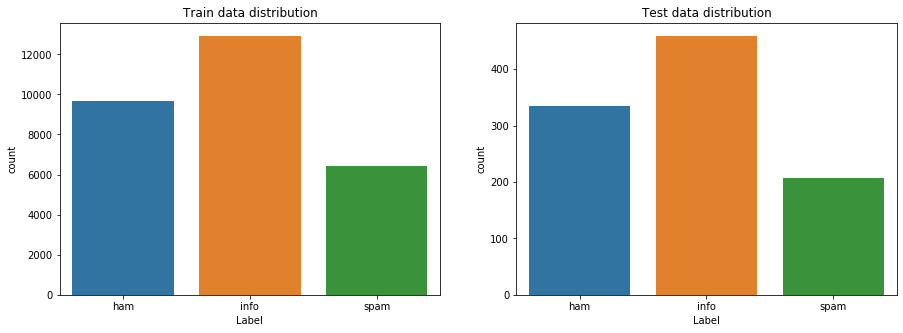

In [29]:
fig, ax = plt.subplots(1, 2, figsize = (15,5))
sns.countplot(train_data.Label, ax = ax[0])
ax[0].set_title('Train data distribution')

sns.countplot(test_data.Label, ax = ax[1])
ax[1].set_title('Test data distribution')
plt.show()

# Data Preparation

Keras requires the data to be in a certain format before building a model and training it. 

`Tokenizer` is a class which helps tokenize words from the corpus and represent them in the form of integer indices. While instantiating this class, you can specify the maximum number of words which you want to consider. If there are more words, then keras will keep only the number of words equal to maximum number of words based on **word frequency**. There are some default parameters which all fit our purpose so, I'm not changing them. You can look at them [here](https://keras.io/preprocessing/text/).

`fit_on_texts` method from the `Tokenizer` object helps to create the word vocabulary

`texts_to_sequences` method can be called after fitting the Tokenizer on the text corpus and converts each sentence into integer index array.

Next, keras needs the input sentences to be all of the same length. There are two ways to achieve this:

- Either find the sentence with max length and pad every other sentence to match its length
- Or arbit define a max length and scale every sentence to that length. This will pad the shorter and truncate the longer sentences (base length - user defined max length).

We'll use the second method. I've implemented the first method in another jupyter notebook from [this classification example using word embeddings](https://github.com/ElisonSherton/Word_Embeddings_in_Keras). You can check that out if you'd like.

In [32]:
# Arbitrarily consider maximum words as 30k and max length of a sentence to be 250
Max_words = 30000
Max_sentence_length = 250

In [44]:
Tk = Tokenizer(num_words = Max_words)

# Fit on the train corpus
Tk.fit_on_texts(train_data.Message)

# Get the integer sequences
seq_train = Tk.texts_to_sequences(train_data.Message)
seq_test = Tk.texts_to_sequences(test_data.Message)

# Pad the sequences or truncate if necessary
# Pad values post the sequence if it's shorter than 250 words long
pad_train = pad_sequences(seq_train, maxlen = Max_sentence_length, padding = "post")
pad_test = pad_sequences(seq_test, maxlen = Max_sentence_length, padding = "post")

In [42]:
# Let's investigate the number of unique words found and the indices assigned by Tokenizer

w = Tk.word_index
print(f"There are {len(w)} number of unique words that appear in the corpus and we're only considering {Max_words} number of words based on the most frequently occuring words")

print("\nThe top 10 words with their wordcounts are as follows:")

top_10 = sorted(Tk.word_counts, key = lambda x:Tk.word_counts[x], reverse = True)[:10]
top_10_freq = [Tk.word_counts[x] for x in top_10]

for i, j in zip(top_10, top_10_freq):
    print(i, j)

There are 38393 number of unique words that appear in the corpus and we're only considering 30000 number of words based on the most frequently occuring words

The top 10 words with their wordcounts are as follows:
for 18686
your 15182
at 12313
on 11836
is 10770
the 8981
to 8388
you 7629
in 6008
of 5096


In [45]:
# Let's view the padded train documents from above
pad_train[:5]

array([[ 651,  474, 1026, ...,    0,    0,    0],
       [ 168,    7, 7036, ...,    0,    0,    0],
       [  30,    8,    1, ...,    0,    0,    0],
       [ 154,   12,  250, ...,    0,    0,    0],
       [5386,    5,  246, ...,    0,    0,    0]])

We need to first convert spam, ham and info into integer representations and then one-hot encode them to feed them to the Neural Network model. 

In [49]:
le = LabelEncoder().fit(train_data.Label)
train_labels = le.transform(train_data.Label)
test_labels = le.transform(test_data.Label)

print(le.classes_)
print(np.unique(train_labels, return_counts = True))
print(np.unique(test_labels, return_counts = True))

['ham' 'info' 'spam']
(array([0, 1, 2]), array([ 9666, 12916,  6418], dtype=int64))
(array([0, 1, 2]), array([334, 459, 207], dtype=int64))


In [50]:
train_labels = to_categorical(np.asarray(train_labels))
test_labels = to_categorical(np.asarray(test_labels))

In [51]:
train_labels[:3]

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.]], dtype=float32)

We can see we've converted out labels into one hot encoded vectors with '0' representing ham, '1' representing info and '2' representing spam respectively. 

In [55]:
lengths = [len(i) for i in seq_train]

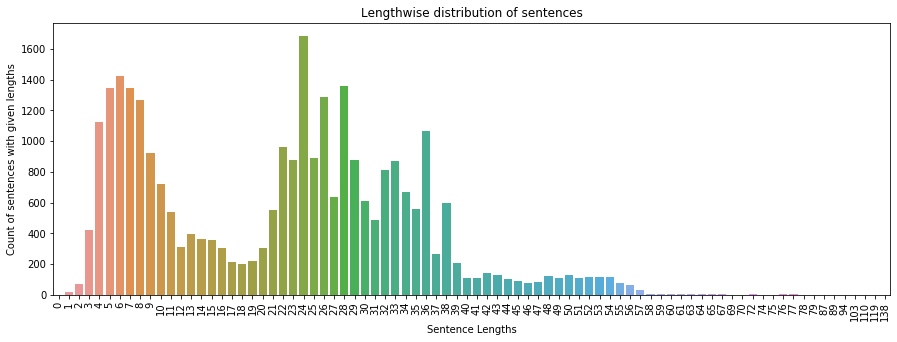

In [62]:
sentence_lengths = np.unique(lengths, return_counts=True)
ln = sentence_lengths[0]
count = sentence_lengths[1]
rcParams['figure.figsize'] = 15,5
sns.barplot(x = ln, y = count)
plt.xlabel('Sentence Lengths')
plt.ylabel('Count of sentences with given lengths')
plt.title('Lengthwise distribution of sentences')
plt.xticks(rotation = 90)
plt.show()

We see that there are no sentences which have a length of more than 138 words. This means that we're unnecessarily padding the sentences to make their length 250. Let's rectify this and let's set the max length of a sentence to 100 and recompute the pad_train and pad_test sequences.

In [63]:
Max_sentence_length = 100

# Pad the sequences or truncate if necessary
# Pad values post the sequence if it's shorter than 100 words long
pad_train = pad_sequences(seq_train, maxlen = Max_sentence_length, padding = "post")
pad_test = pad_sequences(seq_test, maxlen = Max_sentence_length, padding = "post")

Now we're ready to build our model as our data is in shape and ready to be fed to the model for training. 

# Model Architecture

Convolution on a sentence/passage comprising of text is a 1-D operation. Why?

Every word in a sentence will be represented as a word embedding vector and we will get a sentence matrix of s * d dimensions. Here s = 100, since we're making every sentence 100 words long and d is the embedding dimension which we can arbit decide. 

But the key thing here is that although we have a matrix, we want to convolve only along the height and not the width. This is because each vector is representative of one word. That vector together defines a quantum of our input. Convolving widthwise will have some unintended unknown consequences. Hence it's essential to have a Conv1D layer instead of a Conv2D layer to perform this task. The image below helps understand this better.

![1-Dimensional Convolution along text](1d_Convolution.png)

[Image Source](https://missinglink.ai/wp-content/uploads/2019/03/1D-convolutional-example_2x.png)

Apart from this, everything else remains the same. We still have subsampling layers like MaxPooling1D to perform dimensionality reduction and also fully connected layers at end to do classification based on the extracted feature hierarchies. 

In [70]:
embedding_dim = 50

model = Sequential()
model.add(Embedding(Max_words,
                    embedding_dim,
                    input_length = Max_sentence_length
                    ))
# Adding 64 filters to identify relationships
# Kernel size is 5 followed by ReLU activation
model.add(Conv1D(64, 5, activation='relu'))

# Adding another Convolutional layer with 128 filters
model.add(Conv1D(128, 5, activation='relu'))

# Subsampling using max-pooling operation
model.add(MaxPooling1D(pool_size = 2))

# Flattening the input received from above
model.add(Flatten())

# Adding a fully connected layer for classification purposes
model.add(Dense(128, activation='relu'))

# Output layer for multi-class classification
model.add(Dense(3, activation='softmax'))

In [71]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 50)           1500000   
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 96, 64)            16064     
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 92, 128)           41088     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 46, 128)           0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 5888)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               753792    
_________________________________________________________________
dense_8 (Dense)              (None, 3)                

# Compile and fit the model

In [73]:
bsz = 100
num_epochs = 10

In [72]:
# We will fit the model using adam as our optimizer, categorical cross entropy as our loss function and accuracy as our metric
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [74]:
# Let's split training data into 80% Training, 20% Validation and evaluate the model performance after every 5 epochs
model.fit(pad_train, train_labels, validation_split = 0.2, validation_freq = 5, epochs = num_epochs, batch_size = bsz)

Instructions for updating:
Use tf.cast instead.
Train on 23200 samples, validate on 5800 samples
Epoch 1/10
23200/23200 [==============================] - 40s 2ms/step - loss: 0.0906 - accuracy: 0.9639
Epoch 2/10
23200/23200 [==============================] - 38s 2ms/step - loss: 0.0068 - accuracy: 0.9982
Epoch 3/10
23200/23200 [==============================] - 39s 2ms/step - loss: 0.0018 - accuracy: 0.9996
Epoch 4/10
23200/23200 [==============================] - 39s 2ms/step - loss: 6.8046e-04 - accuracy: 0.9999
Epoch 5/10
23200/23200 [==============================] - 43s 2ms/step - loss: 3.7683e-04 - accuracy: 1.0000 - val_loss: 0.0291 - val_accuracy: 0.9941
Epoch 6/10
23200/23200 [==============================] - 42s 2ms/step - loss: 1.7731e-04 - accuracy: 1.0000 0s - loss: 1.7802e-04 - accuracy: 1.00
Epoch 7/10
23200/23200 [==============================] - 42s 2ms/step - loss: 0.0183 - accuracy: 0.9956
Epoch 8/10
23200/23200 [==============================] - 44s 2ms/step - lo

# Evaluate the model

In [103]:
def evaluate_performance(y_true, y_pred, title, labels):    
    data = confusion_matrix(y_true, y_pred)
    data = pd.DataFrame(data/np.sum(data), index = labels, columns = labels)
    print(data)
    akws = {"ha": 'center',"va": 'center', 'size':15}
    sns.heatmap(data, annot = True, annot_kws=akws)
    plt.suptitle(title)
    plt.xticks(rotation = 90); plt.yticks(rotation = 0)
    plt.show()

Performance on Train data

           ham      info      spam
ham   0.333103  0.000000  0.000207
info  0.000000  0.445379  0.000000
spam  0.000414  0.000034  0.220862


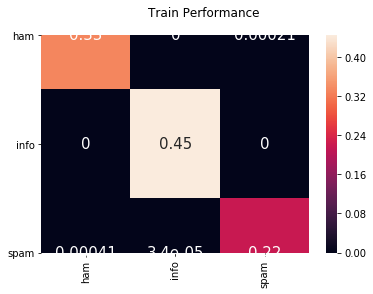

Performance on Test data

        ham   info   spam
ham   0.334  0.000  0.000
info  0.000  0.459  0.000
spam  0.004  0.000  0.203


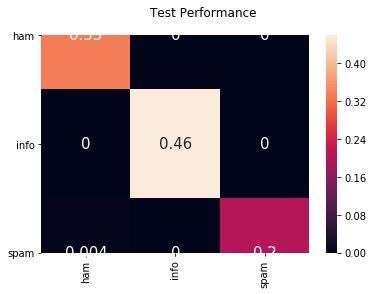

In [104]:
print("Performance on Train data\n")

y_pred_train = np.argmax(model.predict(pad_train), axis = 1)
y_true_train = np.argmax(train_labels, axis = 1)
evaluate_performance(y_true_train, y_pred_train, title = 'Train Performance',
                     labels = le.classes_)

print("Performance on Test data\n")
y_pred_test = np.argmax(model.predict(pad_test), axis = 1)
y_true = np.argmax(test_labels, axis = 1)
evaluate_performance(y_true, y_pred_test, title = 'Test Performance',
                     labels = le.classes_)

# Conclusion

We saw in this notebook how can convolutional neural networks be used for dealing with text classification and for this relatively small dataset, it performed well.

In the next notebook in this repo, we'll see how we can use something better (RNN esp. LSTM) to deal with this task in a better way.